# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV, train_test_split
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from xgboost.sklearn import XGBRegressor
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
#from pandas_profiling import ProfileReport

# magic word for producing visualizations in notebook
%matplotlib inline
plt.rcParams["figure.figsize"] = (18,8)

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
np.set_printoptions(edgeitems=10)
np.core.arrayprint._line_width = 180

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [3]:
%%time
#Load AZDIAS and get summary stats

azdias = pd.read_csv('arvato_data/Udacity_AZDIAS_052018.csv',  dtype={18:'str',19:'str'}, sep=';')
print(azdias.info())
print(azdias.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Columns: 366 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(93), object(6)
memory usage: 2.4+ GB
None
                LNR       AGER_TYP     AKT_DAT_KL       ALTER_HH  \
count  8.912210e+05  891221.000000  817722.000000  817722.000000   
mean   6.372630e+05      -0.358435       4.421928      10.864126   
std    2.572735e+05       1.198724       3.638805       7.639683   
min    1.916530e+05      -1.000000       1.000000       0.000000   
25%    4.144580e+05      -1.000000       1.000000       0.000000   
50%    6.372630e+05      -1.000000       3.000000      13.000000   
75%    8.600680e+05      -1.000000       9.000000      17.000000   
max    1.082873e+06       3.000000       9.000000      21.000000   

        ALTER_KIND1   ALTER_KIND2  ALTER_KIND3  ALTER_KIND4  \
count  81058.000000  29499.000000  6170.000000  1205.000000   
mean      11.745392     13.402658    14.476013    15.089627   


In [4]:
#Get list of columns with mostly missing values
percent_missing = azdias.isna().mean().round(4) * 100
percent_missing.sort_values(inplace=True)
drop_list = percent_missing[percent_missing > 30.0 ]
print(drop_list)
#percent_missing.plot()

KK_KUNDENTYP    65.60
EXTSEL992       73.40
ALTER_KIND1     90.90
ALTER_KIND2     96.69
ALTER_KIND3     99.31
ALTER_KIND4     99.86
dtype: float64


In [5]:
percent_missing_rows = azdias.isna().mean(axis=1).round(4) * 100
percent_missing_rows.sort_values(inplace=True)
percent_missing_rows[percent_missing_rows > 50.0 ].count()

99231

In [6]:
corr_df = azdias.corr()
high_corr = corr_df.applymap(lambda x: abs(x) > 0.96)
a_list = high_corr.sum().sort_values()
high_corr_list = a_list[a_list > 1]
corr_df.loc[high_corr_list.index, high_corr_list.index]

,LP_LEBENSPHASE_GROB,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,KBA13_GBZ,LP_LEBENSPHASE_FEIN,KBA13_FAB_SONSTIGE,KBA13_HHZ,ANZ_HAUSHALTE_AKTIV,PLZ8_GBZ,PLZ8_HHZ,KBA13_KMH_250,KBA13_KMH_211,KBA13_HERST_SONST,LP_FAMILIE_FEIN,ANZ_STATISTISCHE_HAUSHALTE
LP_LEBENSPHASE_GROB,1.000000,0.957661,0.390511,0.407881,0.153845,0.989961,-0.069172,-0.069047,-0.177847,0.152153,-0.064933,-0.000401,-0.000817,-0.069172,0.942819,-0.177903
LP_FAMILIE_GROB,0.957661,1.000000,0.234589,0.245960,0.109975,0.941647,-0.058545,-0.048613,-0.129295,0.108347,-0.046411,-0.004564,-0.004727,-0.058545,0.984100,-0.131622
LP_STATUS_FEIN,0.390511,0.234589,1.000000,0.982411,0.358554,0.443415,-0.106164,-0.122229,-0.372640,0.356850,-0.109888,0.038974,0.037655,-0.106164,0.236180,-0.367039
LP_STATUS_GROB,0.407881,0.245960,0.982411,1.000000,0.346147,0.463909,-0.104668,-0.107028,-0.357599,0.344592,-0.095378,0.051409,0.050484,-0.104668,0.241076,-0.351731
KBA13_GBZ,0.153845,0.109975,0.358554,0.346147,1.000000,0.178266,-0.169633,0.475506,-0.292483,0.979854,0.489083,0.127471,0.127423,-0.169633,0.107839,-0.286385
LP_LEBENSPHASE_FEIN,0.989961,0.941647,0.443415,0.463909,0.178266,1.000000,-0.074396,-0.074577,-0.201056,0.176442,-0.069709,0.004134,0.003681,-0.074396,0.917662,-0.200118
KBA13_FAB_SONSTIGE,-0.069172,-0.058545,-0.106164,-0.104668,-0.169633,-0.074396,1.000000,0.018634,0.063624,-0.167843,0.023256,-0.014234,-0.012642,1.000000,-0.059229,0.063293
KBA13_HHZ,-0.069047,-0.048613,-0.122229,-0.107028,0.475506,-0.074577,0.018634,1.000000,0.094123,0.475023,0.968725,0.106656,0.109367,0.018634,-0.047557,0.092390
ANZ_HAUSHALTE_AKTIV,-0.177847,-0.129295,-0.372640,-0.357599,-0.292483,-0.201056,0.063624,0.094123,1.000000,-0.291662,0.086214,-0.024765,-0.023419,0.063624,-0.125571,0.976900
PLZ8_GBZ,0.152153,0.108347,0.356850,0.344592,0.979854,0.176442,-0.167843,0.475023,-0.291662,1.000000,0.497958,0.126185,0.126570,-0.167843,0.106649,-0.285719


In [13]:
# Functions to clean and preprocess datasets

drop_cols = ['LNR', 'KK_KUNDENTYP', 'ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'EXTSEL992', 
'CAMEO_DEU_2015', 'CAMEO_DEUG_2015', 'CAMEO_INTL_2015', 'D19_LETZTER_KAUF_BRANCHE', 'EINGEZOGENAM_HH_JAHR', 
'EINGEFUEGT_AM', 'ALTERSKATEGORIE_FEIN', 'D19_WEIN_FEINKOST', 'PRAEGENDE_JUGENDJAHRE', 'EINGEFUEGT_AM',  
'D19_VERSAND_ONLINE_DATUM', 'D19_VERSAND_DATUM', 'LP_FAMILIE_FEIN', 'LP_LEBENSPHASE_FEIN', 'LP_STATUS_FEIN',
'ANZ_STATISTISCHE_HAUSHALTE', 'D19_VERSAND_ANZ_24']

def clean_dataset(df):
    df.dropna(thresh=335, inplace=True)
    df.drop(drop_cols, axis=1, inplace=True)
    return(df)

def preprocess_data(df):
    # Replace east and west chars with numbers
    #df.loc[:, 'OST_WEST_KZ'].replace({'W':0, 'O':1}, inplace=True);

    imp = SimpleImputer(missing_values=float("NaN"), strategy="most_frequent", copy = False)
    processed_df = imp.fit_transform(df)
    
    s_scaler = StandardScaler()
    processed_df = pd.DataFrame(s_scaler.fit_transform(processed_df))
    processed_df.columns = df.columns
    
    return(pd.DataFrame(processed_df ))

In [8]:
azdias.info()
clean_dataset(azdias)
azdias.info()
azdias.to_csv('arvato_data/AZDIAS_dropped.csv', sep=';')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Columns: 366 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(93), object(6)
memory usage: 2.4+ GB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 750604 entries, 1 to 891220
Columns: 343 entries, AGER_TYP to ALTERSKATEGORIE_GROB
dtypes: float64(255), int64(87), object(1)
memory usage: 1.9+ GB


In [26]:
azdias_preprocessed  = preprocess_data(azdias)

In [11]:
# load in the data
customers = pd.read_csv('arvato_data/Udacity_CUSTOMERS_052018.csv',  dtype={18:'str',19:'str'}, sep=';')
# Drop the extra column of customers dataset.
customers.drop(columns=['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'], inplace=True)

In [12]:
print(customers.shape)
print(customers.info())
print(customers.describe())
customers_missing_rows = customers.isna().mean(axis=1).round(4) * 100
customers_missing_rows.sort_values(inplace=True)
customers_missing_rows[customers_missing_rows > 80.0 ].count()

(191652, 366)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191652 entries, 0 to 191651
Columns: 366 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(93), object(6)
memory usage: 535.2+ MB
None
                 LNR       AGER_TYP     AKT_DAT_KL       ALTER_HH  \
count  191652.000000  191652.000000  145056.000000  145056.000000   
mean    95826.500000       0.344359       1.747525      11.352009   
std     55325.311233       1.391672       1.966334       6.275026   
min         1.000000      -1.000000       1.000000       0.000000   
25%     47913.750000      -1.000000       1.000000       8.000000   
50%     95826.500000       0.000000       1.000000      11.000000   
75%    143739.250000       2.000000       1.000000      16.000000   
max    191652.000000       3.000000       9.000000      21.000000   

        ALTER_KIND1  ALTER_KIND2  ALTER_KIND3  ALTER_KIND4  \
count  11766.000000  5100.000000  1275.000000   236.000000   
mean      12.337243    13.672353    14.6

0

In [13]:
customers.head()
customers_missing_rows = customers.isna().mean(axis=1).round(4) * 100
customers_missing_rows.sort_values(inplace=True)
print(customers_missing_rows[customers_missing_rows > 60.0 ].count())

49930


In [25]:
customers.info()
clean_dataset(customers)
customers_preprocessed = preprocess_data(customers)
print(customers_preprocessed.info())
print(customers_preprocessed.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 135051 entries, 0 to 191651
Columns: 343 entries, AGER_TYP to ALTERSKATEGORIE_GROB
dtypes: float64(255), int64(88)
memory usage: 354.4 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135051 entries, 0 to 135050
Columns: 343 entries, AGER_TYP to ALTERSKATEGORIE_GROB
dtypes: float64(343)
memory usage: 353.4 MB
None
   AGER_TYP  AKT_DAT_KL  ALTER_HH  ANZ_HAUSHALTE_AKTIV  ANZ_HH_TITEL  \
0  0.914267   -0.369655 -0.212081            -0.281147     -0.127196   
1 -1.360120   -0.369655 -0.850827            -0.281147     -0.127196   
2  0.156138   -0.369655 -0.531454            -0.352841     -0.127196   
3 -1.360120   -0.369655  1.384786             0.149018     -0.127196   
4  0.156138   -0.369655 -0.052394            -0.281147     -0.127196   

   ANZ_KINDER  ANZ_PERSONEN  ANZ_TITEL    ARBEIT  BALLRAUM  ...       VHN  \
0   -0.264751     -0.202478  -0.134442 -1.817040 -0.611956  ...  0.502318   
1   -0.264751     -0.916295  -0.134442  0.1

In [ ]:
#azdias = pd.read_csv('arvato_data/AZDIAS_dropped.csv',  sep=';', index_col=0)
azdias_preprocessed = pd.read_csv('arvato_data/AZDIAS_cleaned.csv', sep=';')
azdias_preprocessed.drop(azdias_preprocessed.columns[0], axis=1, inplace=True)
print(azdias_preprocessed.info())
print(azdias_preprocessed.describe())
print(azdias_preprocessed.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750604 entries, 0 to 750603
Columns: 343 entries, AGER_TYP to ALTERSKATEGORIE_GROB
dtypes: float64(343)
memory usage: 1.9 GB
None


In [3]:
azdias_preprocessed

,AGER_TYP,AKT_DAT_KL,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_TITEL,ARBEIT,BALLRAUM,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,-0.572979,1.249407,-1.417136,0.159141,-0.128334,-0.296889,0.233213,-0.060628,-0.190359,0.851519,...,1.367375,0.681651,1.055463,1.452298,-0.601795,0.548461,-0.028548,1.139257,0.957594,-1.684810
1,-0.572979,1.249407,0.809426,0.095291,-0.128334,-0.296889,-0.626902,-0.060628,-0.190359,-0.975355,...,-0.359341,1.031493,0.441258,0.018122,-0.601795,0.548461,-1.085614,1.139257,0.957594,0.164104
2,1.857962,-0.942516,0.285529,-0.479357,-0.128334,-0.296889,-1.487017,-0.060628,-1.195149,-0.061918,...,-2.086056,0.331809,0.748360,1.810842,0.981839,0.548461,1.557051,-0.284771,0.957594,1.088562
3,-0.572979,-0.942516,1.202349,-0.351657,-0.128334,-0.296889,1.953443,-0.060628,0.814431,-0.975355,...,-0.359341,-1.067560,-0.787153,-0.698965,-1.129672,0.548461,-0.557081,0.427243,-1.044283,0.164104
4,2.668276,-0.942516,-0.107394,-0.223958,-0.128334,-0.296889,-0.626902,-0.060628,-1.195149,0.851519,...,-0.359341,1.381336,-0.172947,-0.698965,0.981839,0.548461,1.557051,0.427243,0.957594,-1.684810
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
750599,-0.572979,0.153446,0.809426,0.414540,-0.128334,-0.296889,-0.626902,-0.060628,0.814431,0.851519,...,-0.359341,-0.717718,-0.172947,0.735210,-0.601795,-2.097491,-0.557081,0.427243,0.957594,0.164104
750600,-0.572979,1.249407,0.678452,0.159141,-0.128334,-0.296889,-0.626902,-0.060628,0.814431,1.308238,...,1.367375,-0.018033,0.441258,0.018122,0.981839,0.548461,0.499985,1.851272,-1.044283,-0.760353
750601,-0.572979,-0.942516,0.809426,-0.351657,-0.128334,-0.296889,-1.487017,-0.060628,-1.195149,0.394801,...,-0.359341,0.331809,0.748360,0.735210,0.981839,-1.568300,1.557051,0.427243,0.957594,-0.760353
750602,-0.572979,1.249407,-1.417136,-0.096258,-0.128334,1.763484,-0.626902,-0.060628,0.814431,-0.975355,...,1.367375,1.031493,0.134155,-0.340421,-1.657550,0.548461,0.499985,1.139257,-1.044283,-1.684810


## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

In [51]:
def scree_plot(pca):
    sns.set_style("darkgrid")
    num_components = len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
    
    plt.figure(figsize=(14,8))
    ax = plt.subplot(111)
    plt.style.use("ggplot")
    
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals,color='teal')
    
    ax.annotate(r"%s%%" % ((str(vals[0]*100)[:4])), (ind[0]+0.2,vals[0]), va='bottom',ha='center',fontsize=12)
        
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=1,length=12)
    
    ax2 = ax.twinx()
    ax2.plot(np.cumsum(pca.explained_variance_ratio_), label='Cumulative Variance',linewidth=2, color = 'red');
    
    n_components = min(np.where(np.cumsum(pca.explained_variance_ratio_)>0.85)[0]+1)
    ax2.axhline(np.cumsum(pca.explained_variance_ratio_)[n_components], linestyle='dashed', color='black')
    
    ax.set_xlabel("Principal Component",fontsize=13)
    ax.set_ylabel("Variance Explained (%)",fontsize=13)
    plt.title("Explained Variance for 140 Components - {}".format(cumvals[-1]),fontsize=15)
    #ax.set_title('n_components needed for >%60 explained variance: {}'.format(n_components));
    
#    plt.show()
    plt.savefig('PCA_Variances')


In [5]:
azdias_preprocessed

,AGER_TYP,AKT_DAT_KL,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_TITEL,ARBEIT,BALLRAUM,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,-0.572979,1.249407,-1.417136,0.159141,-0.128334,-0.296889,0.233213,-0.060628,-0.190359,0.851519,...,1.367375,0.681651,1.055463,1.452298,-0.601795,0.548461,-0.028548,1.139257,0.957594,-1.684810
1,-0.572979,1.249407,0.809426,0.095291,-0.128334,-0.296889,-0.626902,-0.060628,-0.190359,-0.975355,...,-0.359341,1.031493,0.441258,0.018122,-0.601795,0.548461,-1.085614,1.139257,0.957594,0.164104
2,1.857962,-0.942516,0.285529,-0.479357,-0.128334,-0.296889,-1.487017,-0.060628,-1.195149,-0.061918,...,-2.086056,0.331809,0.748360,1.810842,0.981839,0.548461,1.557051,-0.284771,0.957594,1.088562
3,-0.572979,-0.942516,1.202349,-0.351657,-0.128334,-0.296889,1.953443,-0.060628,0.814431,-0.975355,...,-0.359341,-1.067560,-0.787153,-0.698965,-1.129672,0.548461,-0.557081,0.427243,-1.044283,0.164104
4,2.668276,-0.942516,-0.107394,-0.223958,-0.128334,-0.296889,-0.626902,-0.060628,-1.195149,0.851519,...,-0.359341,1.381336,-0.172947,-0.698965,0.981839,0.548461,1.557051,0.427243,0.957594,-1.684810
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
750599,-0.572979,0.153446,0.809426,0.414540,-0.128334,-0.296889,-0.626902,-0.060628,0.814431,0.851519,...,-0.359341,-0.717718,-0.172947,0.735210,-0.601795,-2.097491,-0.557081,0.427243,0.957594,0.164104
750600,-0.572979,1.249407,0.678452,0.159141,-0.128334,-0.296889,-0.626902,-0.060628,0.814431,1.308238,...,1.367375,-0.018033,0.441258,0.018122,0.981839,0.548461,0.499985,1.851272,-1.044283,-0.760353
750601,-0.572979,-0.942516,0.809426,-0.351657,-0.128334,-0.296889,-1.487017,-0.060628,-1.195149,0.394801,...,-0.359341,0.331809,0.748360,0.735210,0.981839,-1.568300,1.557051,0.427243,0.957594,-0.760353
750602,-0.572979,1.249407,-1.417136,-0.096258,-0.128334,1.763484,-0.626902,-0.060628,0.814431,-0.975355,...,1.367375,1.031493,0.134155,-0.340421,-1.657550,0.548461,0.499985,1.139257,-1.044283,-1.684810


In [4]:
%%time
#Use PCA to reduce complexity of the dataset
from sklearn.decomposition import PCA

pca = PCA(140)
df_pca = pca.fit_transform(azdias_preprocessed)


Wall time: 34min 19s


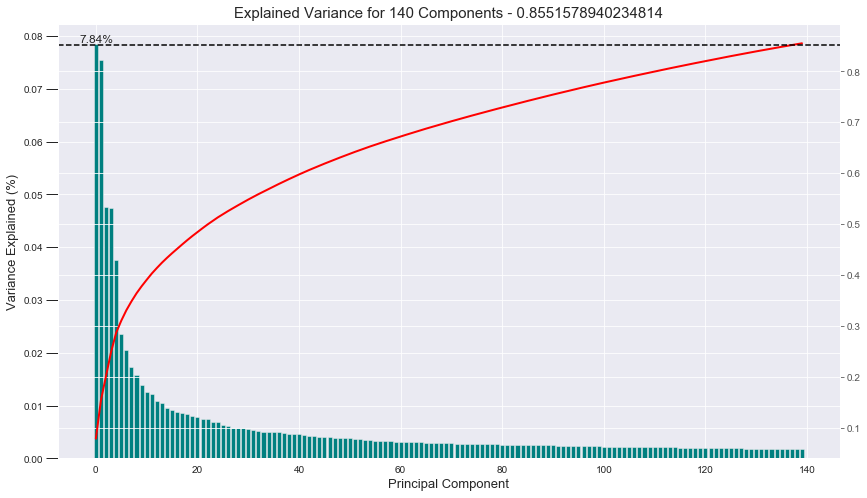

In [52]:
scree_plot(pca)

In [46]:
%%time
from sklearn.cluster import KMeans

def fetch_score(data, center):
    kmeans = KMeans(n_clusters=center, random_state=42)
    km_model = kmeans.fit(data)
    score = abs(km_model.score(data))
    return(score)


scores = []
for i in range(2, 28, 2):
    s = fetch_score(df_pca_sub, i)
    scores.append(s)
    print('i: {}, s: {}'.format(i,s))


i: 2, s: 32107795.638559457
i: 4, s: 28756856.173699785
i: 6, s: 27532434.127998006
i: 8, s: 26771138.79778634
i: 10, s: 26212247.46915828
i: 12, s: 25804769.57756966
i: 14, s: 25468221.86747202
i: 16, s: 25210328.93755425
i: 18, s: 24997205.38342546
i: 20, s: 24780420.427106295
i: 22, s: 24549395.26688052
i: 24, s: 24316974.036438864
i: 26, s: 24142343.215039134
Wall time: 24min 51s
Parser   : 512 ms


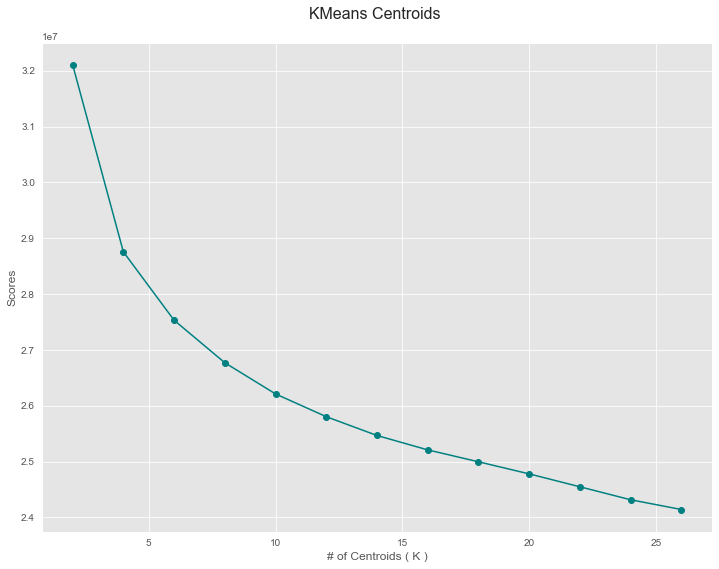

In [50]:
plt.figure(figsize=(12,9))
centers = [2,4,6,8,10,12,14,16,18,20,22,24,26]
plt.plot(centers, scores, linestyle='-', marker='o', color='teal')
plt.title('KMeans Centroids \n', size=16 )
plt.xlabel('# of Centroids ( K )')
plt.ylabel('Scores')
#plt.show()
plt.savefig('kmeans')

In [37]:
%%time
df_pca_sub = df_pca[np.random.choice(df_pca.shape[0], 120000, replace=False),:]
df_pca_sub.shape

Wall time: 4min 52s


(120000, 140)

In [5]:
%%time
# Re-fit and predict the k-means model with the selected 14 clusters
kmeans = KMeans(n_clusters=14)
pop_predict = kmeans.fit_predict(df_pca)

Wall time: 15min 9s
Parser   : 114 ms


In [8]:
customers_preprocessed = pd.read_csv('arvato_data/CUSTOMERS_cleaned.csv', sep=';')
customers_preprocessed.drop(customers_preprocessed.columns[0], axis=1, inplace=True)
customers_preprocessed

,AGER_TYP,AKT_DAT_KL,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_TITEL,ARBEIT,BALLRAUM,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,0.914267,-0.369655,-0.212081,-0.281147,-0.127196,-0.264751,-0.202478,-0.134442,-1.817040,-0.611956,...,0.502318,0.223609,-0.518992,-0.498829,0.871836,0.278574,1.584820,0.457019,-0.701918,0.650473
1,-1.360120,-0.369655,-0.850827,-0.281147,-0.127196,-0.264751,-0.916295,-0.134442,0.166624,1.277512,...,1.378005,1.925671,2.941938,3.566436,0.871836,0.278574,-0.837562,0.457019,1.424668,0.650473
2,0.156138,-0.369655,-0.531454,-0.352841,-0.127196,-0.264751,-1.630112,-0.134442,-1.817040,1.277512,...,-0.373368,0.564022,-0.172899,-0.498829,0.871836,0.278574,1.584820,-1.075715,-0.701918,0.650473
3,-1.360120,-0.369655,1.384786,0.149018,-0.127196,-0.264751,1.225156,-0.134442,0.166624,-0.611956,...,1.378005,-0.457215,0.173194,0.404563,-1.245470,0.278574,-0.353086,-1.075715,-0.701918,-0.671131
4,0.156138,-0.369655,-0.052394,-0.281147,-0.127196,-0.264751,-0.202478,-0.134442,0.166624,1.277512,...,1.378005,-1.138040,-0.865085,-0.950525,0.871836,0.278574,-1.322039,-0.309348,-0.701918,-0.671131
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135046,0.156138,-0.369655,-0.371767,-0.281147,-0.127196,-0.264751,-0.916295,-0.134442,0.166624,-1.556690,...,1.378005,1.244846,1.211473,0.856260,0.871836,0.278574,-1.322039,0.457019,-0.701918,-0.671131
135047,-1.360120,0.150206,-1.808947,-0.352841,-0.127196,-0.264751,-1.630112,-0.134442,-1.817040,0.805145,...,-0.373368,1.925671,0.865380,0.404563,0.871836,0.278574,-0.353086,0.457019,1.424668,0.650473
135048,0.914267,-0.369655,0.586353,-0.281147,-0.127196,-0.264751,0.511339,-0.134442,0.166624,1.277512,...,-1.249055,1.244846,1.211473,0.856260,-0.716144,0.278574,-0.353086,0.457019,-0.701918,0.650473
135049,1.672396,-0.369655,0.266979,-0.066065,-0.127196,-0.264751,1.225156,-0.134442,0.166624,-0.611956,...,0.502318,-1.138040,-1.211178,-0.950525,-0.186817,0.278574,-0.837562,0.457019,1.424668,-0.671131


In [9]:
%%time
# Transform the customer data with the PCA and KMeans models trained on the population data
customers_pca = pca.transform(customers_preprocessed)
prediction_customers = kmeans.predict(customers_pca)

Wall time: 20.3 s


In [97]:
#prepare the customer clusters for plotting; get percentage and counts
customer_cluster = pd.DataFrame({'cluster':prediction_customers})
customer_counts = customer_cluster.groupby(['cluster']).size().reset_index(name='counts')
customer_counts['percent'] = customer_counts['counts']/customer_cluster.shape[0]*100
customer_counts['type'] = 'Customers'
t_df=pd.DataFrame({'cluster':list(range(14)), 'counts':[0]*14, 'percent':[0]*14})
customer_counts = pd.merge(customer_counts,t_df, on='cluster', how='right').fillna(0)

#prepare the customer clusters for plotting; get percentage and counts
global_cluster = pd.DataFrame({'cluster':pop_predict})
global_counts = global_cluster.groupby(['cluster']).size().reset_index(name='counts')
global_counts['percent'] = global_counts['counts']/global_cluster.shape[0]*100
global_counts['type'] = 'Population'

t_df=pd.DataFrame({'cluster':list(range(14)), 'counts':[0]*14, 'percent':[0]*14})
global_counts = pd.merge(global_counts,t_df, on='cluster', how='right').fillna(0)
customer_counts = plot_df.append(gc_temp)

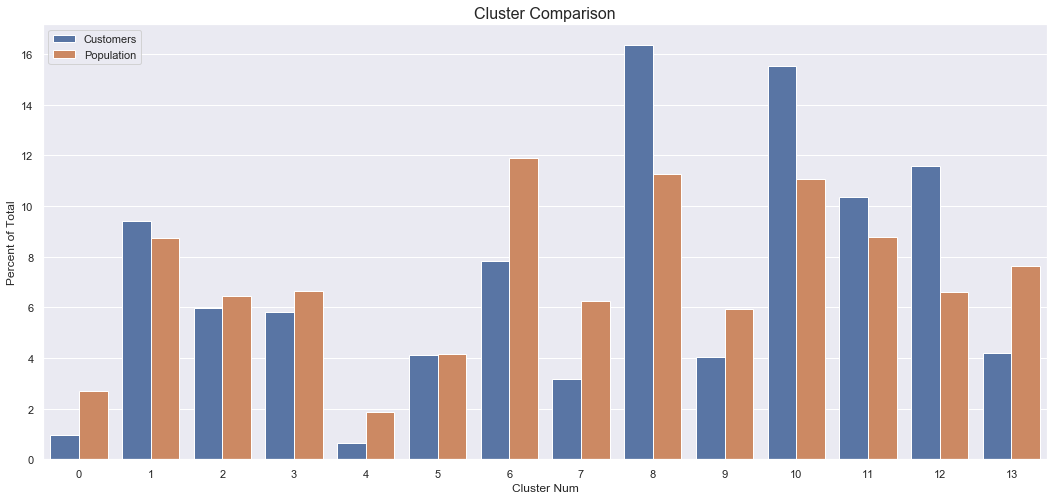

In [106]:

plt.figure(figsize=(18,8))
sns.barplot(x='cluster', y='percent_x', hue='type', data=plot_df)
plt.title("Cluster Comparison", size=16)
plt.ylabel('Percent of Total')
plt.xlabel('Cluster Num')

plt.legend(loc='upper left')
plt.savefig('clusters')

In [10]:
def describe_cluster(df1,df2,cluster):

    df1_T = df1[df1['cluster']==cluster].describe().T.sort_values(by='50%',ascending=False)['50%']
    df2_T = df2[df2['cluster']==cluster].describe().T.sort_values(by='50%',ascending=False)['50%']
    df_concat = pd.concat([df1_T,df2_T],axis=1).dropna()
    df_concat.columns = ['population_median', 'customer_median']
    df_concat['difference'] = np.abs(df_concat.population_median - df_concat.customer_median)
    df_concat = df_concat.sort_values(by='difference', ascending=False)
    print(df_concat.head(10))

azdias_preprocessed['cluster'] = pop_predict
customers_preprocessed['cluster'] = prediction_customers

describe_cluster(azdias_preprocessed,customers_preprocessed,0)
describe_cluster(azdias_preprocessed,customers_preprocessed,6)
describe_cluster(azdias_preprocessed,customers_preprocessed,8)
describe_cluster(azdias_preprocessed,customers_preprocessed,12)


c:\users\craig\source\workspaces\coursera_ml_engineering\capstone_project\venv\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """


                      population_median  customer_median  difference
GREEN_AVANTGARDE              -0.531199         0.983527    1.514726
ZABEOTYP                       0.427243        -1.075715    1.502958
D19_BANKEN_GROSS               0.819077        -0.341749    1.160826
D19_GESAMT_ANZ_24              2.110764         1.198492    0.912273
CJT_TYP_6                     -0.301412         0.583731    0.885143
D19_HAUS_DEKO                 -0.493998         0.368367    0.862365
ALTERSKATEGORIE_GROB           0.164104        -0.671131    0.835236
FINANZ_VORSORGER              -0.322522         0.503517    0.826039
CJT_TYP_5                     -0.179239         0.623102    0.802341
KBA05_MOD8                    -0.258143         0.492972    0.751116
                   population_median  customer_median  difference
FINANZTYP                  -1.353541         0.430541    1.784081
ANREDE_KZ                   0.957594        -0.701918    1.659512
AKT_DAT_KL                  1.249407       

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [15]:
#Load and transform data
mailout_train = pd.read_csv('arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', dtype={18:'str',19:'str'}, sep=';')
mailout_test = pd.read_csv('arvato_data/Udacity_MAILOUT_052018_TEST.csv', dtype={18:'str',19:'str'}, sep=';')


def preprocess_data(df):
#    print(mailout_train.info())

    df_na_dropped = df.dropna(thresh=330)

    train_labels = df_na_dropped['RESPONSE']
    df_na_dropped = df_na_dropped.drop(['RESPONSE'], axis=1)
    
    #    print(mailout_train_dropped.info())
    df_na_dropped.drop(drop_cols, axis=1, inplace=True)

    df_na_dropped.loc[:, 'OST_WEST_KZ'].replace({'W':0, 'O':1}, inplace=True);

    imp = SimpleImputer(missing_values=float("NaN"), strategy="most_frequent", copy = False)
    train_features = imp.fit_transform(df_na_dropped)
    
    s_scaler = StandardScaler()
    train_features = s_scaler.fit_transform(train_features)
    return(train_features, train_labels )

In [16]:
print(mailout_train.shape)
print(mailout_train.info())
print(mailout_train.describe())
mailout_train_processed,train_label = preprocess_data(mailout_train)

(42962, 367)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42962 entries, 0 to 42961
Columns: 367 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(94), object(6)
memory usage: 120.3+ MB
None
                LNR      AGER_TYP    AKT_DAT_KL      ALTER_HH  ALTER_KIND1  \
count  42962.000000  42962.000000  35993.000000  35993.000000  1988.000000   
mean   42803.120129      0.542922      1.525241     10.285556    12.606137   
std    24778.339984      1.412924      1.741500      6.082610     3.924976   
min        1.000000     -1.000000      1.000000      0.000000     2.000000   
25%    21284.250000     -1.000000      1.000000      8.000000     9.000000   
50%    42710.000000      1.000000      1.000000     10.000000    13.000000   
75%    64340.500000      2.000000      1.000000     15.000000    16.000000   
max    85795.000000      3.000000      9.000000     21.000000    18.000000   

       ALTER_KIND2  ALTER_KIND3  ALTER_KIND4  ALTERSKATEGORIE_FEIN  \
count   756.0000

In [17]:
print(mailout_test.shape)
print(mailout_test.info())
print(mailout_test.describe())

(42833, 366)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42833 entries, 0 to 42832
Columns: 366 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(93), object(6)
memory usage: 119.6+ MB
None
                LNR      AGER_TYP    AKT_DAT_KL      ALTER_HH  ALTER_KIND1  \
count  42833.000000  42833.000000  35944.000000  35944.000000  2013.000000   
mean   42993.165620      0.537436      1.518890     10.239511    12.534029   
std    24755.599728      1.414777      1.737441      6.109680     3.996079   
min        2.000000     -1.000000      1.000000      0.000000     2.000000   
25%    21650.000000     -1.000000      1.000000      8.000000     9.000000   
50%    43054.000000      1.000000      1.000000     10.000000    13.000000   
75%    64352.000000      2.000000      1.000000     15.000000    16.000000   
max    85794.000000      3.000000      9.000000     21.000000    18.000000   

       ALTER_KIND2  ALTER_KIND3  ALTER_KIND4  ALTERSKATEGORIE_FEIN  \
count   762.0000

In [3]:
mailout_train_missing = mailout_train.isna().mean().round(4) * 100
mailout_train_missing.sort_values(inplace=True)
mailout_train_missing.tail(20)
# Number of Nans
temp_df = mailout_train.drop(drop_cols, axis=1)
mailout_missing_cols = temp_df.isna().sum()
mailout_missing_cols = mailout_missing_cols[mailout_missing_cols> 0]
mailout_missing_cols.index
#mailout_train_missing.sort_values(inplace=True)
#mailout_train_missing.tail(20)
print(type(mailout_missing_cols))

KBA05_MOD4        20.13
KBA05_MOD3        20.13
KBA05_MOD2        20.13
KBA05_MOD1        20.13
KBA05_MAXVORB     20.13
KBA05_MOTRAD      20.13
KBA05_MAXHERST    20.13
KBA05_MAXBJ       20.13
KBA05_MAXAH       20.13
KBA05_KW3         20.13
MOBI_REGIO        20.13
KBA05_KW2         20.13
W_KEIT_KIND_HH    22.53
HH_DELTA_FLAG     22.53
EXTSEL992         37.12
KK_KUNDENTYP      58.93
ALTER_KIND1       95.37
ALTER_KIND2       98.24
ALTER_KIND3       99.59
ALTER_KIND4       99.90
dtype: float64

In [11]:
print(mailout_train['CAMEO_DEU_2015'].nunique())
print(mailout_train.iloc[22398, :20])
print(mailout_train['CAMEO_DEU_2015'].unique())
print(mailout_train['CAMEO_DEUG_2015'].unique())
print(mailout_train['CAMEO_INTL_2015'].unique())
#CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP
mailout_train[mailout_train.eq('1994-03-23 00:00:00').any(1)]
print(mailout_train.iloc[42859, 80:130])
print(mailout_train['OST_WEST_KZ'].unique())

45


In [59]:
# RandomForest
rfc = RandomForestClassifier()

parameters = {
    "n_estimators":[450, 500, 550],
    "max_depth":[3, 4, 5],
    "min_samples_split":[4, 5, 6],
#    "min_samples_leaf":[2,4],
}

# n_estimators = [100, 300, 500, 800, 1200]
#max_depth = [5, 8, 15, 25, 30]
#min_samples_split = [2, 5, 10, 15, 100]
#min_samples_leaf = [1, 2, 5, 10] 

cv = GridSearchCV(rfc,parameters,scoring='roc_auc', cv=5, verbose=5)
cv.fit(mailout_train_processed,train_label.values.ravel())
print(cv.best_params_)
print(cv.best_score_)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] max_depth=3, min_samples_split=4, n_estimators=450 ..............
[CV]  max_depth=3, min_samples_split=4, n_estimators=450, score=0.717, total=  21.4s
[CV] max_depth=3, min_samples_split=4, n_estimators=450 ..............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   21.3s remaining:    0.0s


[CV]  max_depth=3, min_samples_split=4, n_estimators=450, score=0.701, total=  19.0s
[CV] max_depth=3, min_samples_split=4, n_estimators=450 ..............


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   40.3s remaining:    0.0s


[CV]  max_depth=3, min_samples_split=4, n_estimators=450, score=0.776, total=  19.1s
[CV] max_depth=3, min_samples_split=4, n_estimators=450 ..............


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   59.4s remaining:    0.0s


[CV]  max_depth=3, min_samples_split=4, n_estimators=450, score=0.737, total=  19.2s
[CV] max_depth=3, min_samples_split=4, n_estimators=450 ..............


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  1.3min remaining:    0.0s


[CV]  max_depth=3, min_samples_split=4, n_estimators=450, score=0.797, total=  25.0s
[CV] max_depth=3, min_samples_split=4, n_estimators=500 ..............
[CV]  max_depth=3, min_samples_split=4, n_estimators=500, score=0.716, total=  22.0s
[CV] max_depth=3, min_samples_split=4, n_estimators=500 ..............
[CV]  max_depth=3, min_samples_split=4, n_estimators=500, score=0.719, total=  22.1s
[CV] max_depth=3, min_samples_split=4, n_estimators=500 ..............
[CV]  max_depth=3, min_samples_split=4, n_estimators=500, score=0.773, total=  21.6s
[CV] max_depth=3, min_samples_split=4, n_estimators=500 ..............
[CV]  max_depth=3, min_samples_split=4, n_estimators=500, score=0.750, total=  21.9s
[CV] max_depth=3, min_samples_split=4, n_estimators=500 ..............
[CV]  max_depth=3, min_samples_split=4, n_estimators=500, score=0.792, total=  27.9s
[CV] max_depth=3, min_samples_split=4, n_estimators=550 ..............
[CV]  max_depth=3, min_samples_split=4, n_estimators=550, score=

[CV]  max_depth=4, min_samples_split=4, n_estimators=550, score=0.781, total=  44.2s
[CV] max_depth=4, min_samples_split=4, n_estimators=550 ..............
[CV]  max_depth=4, min_samples_split=4, n_estimators=550, score=0.746, total=  48.9s
[CV] max_depth=4, min_samples_split=4, n_estimators=550 ..............
[CV]  max_depth=4, min_samples_split=4, n_estimators=550, score=0.795, total=  47.3s
[CV] max_depth=4, min_samples_split=5, n_estimators=450 ..............
[CV]  max_depth=4, min_samples_split=5, n_estimators=450, score=0.712, total=  32.1s
[CV] max_depth=4, min_samples_split=5, n_estimators=450 ..............
[CV]  max_depth=4, min_samples_split=5, n_estimators=450, score=0.730, total=  30.4s
[CV] max_depth=4, min_samples_split=5, n_estimators=450 ..............
[CV]  max_depth=4, min_samples_split=5, n_estimators=450, score=0.787, total=  31.7s
[CV] max_depth=4, min_samples_split=5, n_estimators=450 ..............
[CV]  max_depth=4, min_samples_split=5, n_estimators=450, score=

[CV]  max_depth=5, min_samples_split=5, n_estimators=500, score=0.722, total=  50.6s
[CV] max_depth=5, min_samples_split=5, n_estimators=500 ..............
[CV]  max_depth=5, min_samples_split=5, n_estimators=500, score=0.719, total=  48.3s
[CV] max_depth=5, min_samples_split=5, n_estimators=500 ..............
[CV]  max_depth=5, min_samples_split=5, n_estimators=500, score=0.771, total=  54.1s
[CV] max_depth=5, min_samples_split=5, n_estimators=500 ..............
[CV]  max_depth=5, min_samples_split=5, n_estimators=500, score=0.747, total=  42.4s
[CV] max_depth=5, min_samples_split=5, n_estimators=500 ..............
[CV]  max_depth=5, min_samples_split=5, n_estimators=500, score=0.800, total=  38.7s
[CV] max_depth=5, min_samples_split=5, n_estimators=550 ..............
[CV]  max_depth=5, min_samples_split=5, n_estimators=550, score=0.705, total=  41.0s
[CV] max_depth=5, min_samples_split=5, n_estimators=550 ..............
[CV]  max_depth=5, min_samples_split=5, n_estimators=550, score=

[Parallel(n_jobs=1)]: Done 135 out of 135 | elapsed: 100.2min finished


{'max_depth': 4, 'min_samples_split': 4, 'n_estimators': 500}
0.7563233140378026


In [79]:
mailout_train_processed
sum(train_label.values)
sum(mailout_train['RESPONSE'])

532

In [80]:
df = pd.DataFrame(mailout_train_processed)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34196 entries, 0 to 34195
Columns: 353 entries, 0 to 352
dtypes: float64(353)
memory usage: 92.1 MB


## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [85]:
X_train, X_test, y_train, y_test = train_test_split(mailout_train_processed, train_label, stratify=train_label, test_size=0.2)

rfc = RandomForestClassifier(max_depth = 4, min_samples_split=5, n_estimators=500)
rfc.fit(X_train,y_train)

#rfc.fit(mailout_train_processed,train_label.values.ravel())

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=4, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [89]:
preds = rfc.predict_proba(X_test)

# Report the before-and-afterscores
print("Unoptimized model\n------")
print("ROC score on testing data: {:.4f}".format(roc_auc_score(y_test, preds[:,1])))


Unoptimized model
------
ROC score on testing data: 0.7281


In [24]:
mailout_test.head(10)

#drop records with too many missing 
#mailout_test_dropped = mailout_test.dropna(thresh=330)
mailout_test_dropped = mailout_test
# Save the LNR for result index
test_LNR = mailout_test_dropped['LNR']

#    print(mailout_train_dropped.info())
# Drop unneeded cols
mailout_test_dropped.drop(drop_cols, axis=1, inplace=True)
#mailout_test_dropped.drop(['RESPONSE'], axis=1, inplace=True)
mailout_test_dropped.loc[:, 'OST_WEST_KZ'].replace({'W':0, 'O':1}, inplace=True);

#impute NaNs
imp = SimpleImputer(missing_values=float("NaN"), strategy="most_frequent", copy = False)
test_features = imp.fit_transform(mailout_test_dropped)

s_scaler = StandardScaler()
test_features = s_scaler.fit_transform(test_features)


In [90]:
# Prediction
rfc = RandomForestClassifier(max_depth = 4, min_samples_split=5, n_estimators=500)
rfc.fit(X_train,y_train)
preds = rfc.predict_proba(X_test)

test_label = rfc.predict_proba(test_features)[:,1]

submission = pd.DataFrame(test_label, index=test_LNR.astype('int32'),
                          columns=["RESPONSE"])

submission.head()

# Save file to submit
submission.to_csv('submission.csv')

In [13]:
# Initial LGBMRegressor tests
reg = lgb.LGBMRegressor()

clf = lgb.LGBMRegressor(random_state=0, learning_rate=0.001, max_depth=8, n_estimators=1500, )
parameters = { 'num_leaves': [80, 100, 120, 140],
              'min_data_in_leaf': [12, 15, 20, 25]
             }


# Grid search it
cv = GridSearchCV(clf, parameters,scoring='roc_auc', cv=5, verbose=5, n_jobs=-1)

# Fit the ...
fitted = cv.fit(mailout_train_processed,train_label.values.ravel())


# Get the estimator and predict
print(cv.best_params_)
print(cv.best_score_)


Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


KeyboardInterrupt: 

In [28]:
%%time
# Some basic training use LGBMRegressor

clf = lgb.LGBMRegressor(
            learning_rate=0.001, 
            lambda_l2 = 0.1,
            random_state=0, 
            max_depth=13,
            n_estimators=1900,
            min_data_in_leaf=20 )

parameters = {
            'num_leaves': [45, 50, 55]
             }

# Perform grid search on the classifier using 'scorer' as the scoring method
grid_obj = GridSearchCV(clf, parameters, scoring = 'roc_auc',  cv=5, verbose=10) # n_jobs=-1,

# Fit the grid search object to the training data and find the optimal parameters
grid_fit = grid_obj.fit(mailout_train_processed,train_label.values.ravel())

# Get the estimator and predict
print(grid_fit.best_estimator_)
print(grid_fit.best_params_)
print(grid_fit.best_score_)


Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] num_leaves=45 ...................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ....................... num_leaves=45, score=0.738, total= 2.1min
[CV] num_leaves=45 ...................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.1min remaining:    0.0s


[CV] ....................... num_leaves=45, score=0.777, total= 1.6min
[CV] num_leaves=45 ...................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.7min remaining:    0.0s


[CV] ....................... num_leaves=45, score=0.804, total= 2.2min
[CV] num_leaves=45 ...................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  5.9min remaining:    0.0s


[CV] ....................... num_leaves=45, score=0.765, total= 2.2min
[CV] num_leaves=45 ...................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  8.1min remaining:    0.0s


[CV] ....................... num_leaves=45, score=0.795, total= 2.2min
[CV] num_leaves=50 ...................................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 10.3min remaining:    0.0s


[CV] ....................... num_leaves=50, score=0.743, total= 2.0min
[CV] num_leaves=50 ...................................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 12.4min remaining:    0.0s


[CV] ....................... num_leaves=50, score=0.777, total= 1.8min
[CV] num_leaves=50 ...................................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed: 14.2min remaining:    0.0s


[CV] ....................... num_leaves=50, score=0.800, total= 2.0min
[CV] num_leaves=50 ...................................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 16.2min remaining:    0.0s


[CV] ....................... num_leaves=50, score=0.775, total= 1.7min
[CV] num_leaves=50 ...................................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 18.0min remaining:    0.0s


[CV] ....................... num_leaves=50, score=0.801, total= 1.7min
[CV] num_leaves=55 ...................................................
[CV] ....................... num_leaves=55, score=0.735, total= 1.9min
[CV] num_leaves=55 ...................................................
[CV] ....................... num_leaves=55, score=0.779, total= 1.6min
[CV] num_leaves=55 ...................................................
[CV] ....................... num_leaves=55, score=0.799, total= 1.7min
[CV] num_leaves=55 ...................................................
[CV] ....................... num_leaves=55, score=0.770, total= 1.8min
[CV] num_leaves=55 ...................................................
[CV] ....................... num_leaves=55, score=0.799, total= 1.8min


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed: 28.6min finished


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', lambda_l2=0.1, learning_rate=0.001,
              max_depth=13, min_child_samples=20, min_child_weight=0.001,
              min_data_in_leaf=20, min_split_gain=0.0, n_estimators=1900,
              n_jobs=-1, num_leaves=50, objective=None, random_state=0,
              reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0)
{'num_leaves': 50}
0.7792485355170605
Wall time: 30min 32s


In [ ]:
# Results from several hyperparameter tuning runs.
{'learning_rate': 0.001, 'max_depth': 10, 'n_estimators': 2000}
0.7738214439485253

{'min_data_in_leaf': 15, 'num_leaves': 80}
0.7663591334356443

In [13]:
clf = lgb.LGBMRegressor(
            learning_rate=0.001, 
            lambda_l2 = 0.1,
            random_state=0, 
            max_depth=13,
            n_estimators=1900,
            min_data_in_leaf=20,
            num_leaves=50)

clf.fit(mailout_train_processed, train_label)
# Prediction
test_label = clf.predict(test_features)

submission = pd.DataFrame(test_label, index=test_LNR.astype('int32'),
                          columns=["RESPONSE"])
submission.head()

# Save file to submit
submission.to_csv('submission.csv')


In [17]:
# Prediction
lgb_preds = test_label

rfc = RandomForestClassifier(max_depth = 4, min_samples_split=5, n_estimators=500)
rfc.fit(mailout_train_processed, train_label)
rf_preds = rfc.predict_proba(test_features)[:,1]



In [25]:
print(lgb_preds)
print(rf_preds)
test_label = (rf_preds+lgb_preds)/2

submission = pd.DataFrame(test_label, index=test_LNR.astype('int32'),
                          columns=["RESPONSE"])

submission.head()

# Save file to submit
submission.to_csv('submission.csv')

[0.03163904 0.01598747 0.00379993 ... 0.00831696 0.04829675 0.03364624]
[0.01774926 0.01750166 0.01237377 ... 0.01357825 0.01087199 0.01260128]


In [18]:
print(grid_fit.best_estimator_)
print(grid_fit.best_params_)
print(grid_fit.best_score_)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.001, max_depth=10,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=2000, n_jobs=-1, num_leaves=31, objective=None,
              random_state=0, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)
{'learning_rate': 0.001, 'max_depth': 10, 'n_estimators': 2000}
0.7738214439485253


In [ ]:
LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', lambda_l2=0.1, learning_rate=0.001,
              max_depth=12, min_child_samples=20, min_child_weight=0.001,
              min_split_gain=0.0, n_estimators=2000, n_jobs=-1, num_leaves=31,
              objective=None, random_state=0, reg_alpha=0.0, reg_lambda=0.0,
              silent=True, subsample=1.0, subsample_for_bin=200000,
              subsample_freq=0)
{'max_depth': 12, 'n_estimators': 2000}
0.7748209259235634
Wall time: 1h 3min 38s
    
LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', lambda_l2=0.1, learning_rate=0.001,
              max_depth=13, min_child_samples=20, min_child_weight=0.001,
              min_split_gain=0.0, n_estimators=1900, n_jobs=-1, num_leaves=31,
              objective=None, random_state=0, reg_alpha=0.0, reg_lambda=0.0,
              silent=True, subsample=1.0, subsample_for_bin=200000,
              subsample_freq=0)
{'max_depth': 13, 'n_estimators': 1900}
0.7778164928266607
Wall time: 1h 7min 34s   
    
LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', lambda_l2=0.1, learning_rate=0.001,
              max_depth=13, min_child_samples=20, min_child_weight=0.001,
              min_data_in_leaf=20, min_split_gain=0.0, n_estimators=1900,
              n_jobs=-1, num_leaves=31, objective=None, random_state=0,
              reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0)
{'min_data_in_leaf': 20}
0.7778164928266607
Wall time: 24min 20s    
    
LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', lambda_l2=0.1, learning_rate=0.001,
              max_depth=13, min_child_samples=20, min_child_weight=0.001,
              min_data_in_leaf=20, min_split_gain=0.0, n_estimators=1900,
              n_jobs=-1, num_leaves=50, objective=None, random_state=0,
              reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0)
{'num_leaves': 50}
0.7792485355170605
Wall time: 27min 33s  
    
LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', lambda_l2=0.1, learning_rate=0.001,
              max_depth=13, min_child_samples=20, min_child_weight=0.001,
              min_data_in_leaf=20, min_split_gain=0.0, n_estimators=1900,
              n_jobs=-1, num_leaves=50, objective=None, random_state=0,
              reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0)
{'num_leaves': 50}
0.7792485355170605
Wall time: 30min 32s    

In [20]:
%%time
# training use XGBRegressor
xgbr = XGBRegressor(objective='binary:logistic',  learning_rate=0.1,
                    random_state=42, max_depth=3, min_child_weight=3,
                    n_estimators=100, gamma=0.0, subsample=0.6, colsample_bytree=0.7)

parameters = {
            'n_estimators':[95, 100, 105]
            #'learning_rate':[0.05, 0.06, 0.07, 0.08, 0.09, 0.1]
             }

# Perform grid search on the classifier using 'scorer' as the scoring method
gcv = GridSearchCV(xgbr, parameters, scoring = 'roc_auc',  cv=5, verbose=10) #, n_jobs=-1)

# Fit the grid search object to the training data and find the optimal parameters
gcv_fit = gcv.fit(mailout_train_processed,train_label.values.ravel())

# Get the estimator and predict
print(gcv_fit.best_estimator_)
print(gcv_fit.best_params_)
print(gcv_fit.best_score_)


Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] n_estimators=95 .................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ..................... n_estimators=95, score=0.757, total=  18.9s
[CV] n_estimators=95 .................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   18.8s remaining:    0.0s


[CV] ..................... n_estimators=95, score=0.775, total=  24.7s
[CV] n_estimators=95 .................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   43.5s remaining:    0.0s


[CV] ..................... n_estimators=95, score=0.817, total=  20.8s
[CV] n_estimators=95 .................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.1min remaining:    0.0s


[CV] ..................... n_estimators=95, score=0.788, total=  22.8s
[CV] n_estimators=95 .................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  1.5min remaining:    0.0s


[CV] ..................... n_estimators=95, score=0.785, total=  20.7s
[CV] n_estimators=100 ................................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.8min remaining:    0.0s


[CV] .................... n_estimators=100, score=0.761, total=  21.5s
[CV] n_estimators=100 ................................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  2.2min remaining:    0.0s


[CV] .................... n_estimators=100, score=0.774, total=  20.4s
[CV] n_estimators=100 ................................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  2.5min remaining:    0.0s


[CV] .................... n_estimators=100, score=0.815, total=  20.8s
[CV] n_estimators=100 ................................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  2.8min remaining:    0.0s


[CV] .................... n_estimators=100, score=0.784, total=  20.6s
[CV] n_estimators=100 ................................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  3.2min remaining:    0.0s


[CV] .................... n_estimators=100, score=0.791, total=  20.4s
[CV] n_estimators=105 ................................................
[CV] .................... n_estimators=105, score=0.759, total=  21.2s
[CV] n_estimators=105 ................................................
[CV] .................... n_estimators=105, score=0.772, total=  21.5s
[CV] n_estimators=105 ................................................
[CV] .................... n_estimators=105, score=0.818, total=  20.4s
[CV] n_estimators=105 ................................................
[CV] .................... n_estimators=105, score=0.779, total=  20.3s
[CV] n_estimators=105 ................................................
[CV] .................... n_estimators=105, score=0.790, total=  20.0s


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:  5.3min finished


XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=0.0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=3, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=0, num_parallel_tree=1,
             objective='binary:logistic', random_state=42, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=0.6, tree_method=None,
             validate_parameters=False, verbosity=None)
{'n_estimators': 100}
0.7850574707646799
Wall time: 5min 39s


In [ ]:
# Results from XGBRegressor grid search runs
'learning_rate':[0.05, 0.06, 0.07, 0.08, 0.09, 0.1]
 XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=0.0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=3, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=0, num_parallel_tree=1,
             objective='binary:logistic', random_state=42, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=0.6, tree_method=None,
             validate_parameters=False, verbosity=None)
{'learning_rate': 0.1}
0.7850574707646799
Wall time: 11min 16s
    
'subsample':[0.55, 0.6, 0.65],
'colsample_bytree':[0.65, 0.7, 0.75, 0.8]
XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=0.0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=3, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=0, num_parallel_tree=1,
             objective='binary:logistic', random_state=42, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=0.6, tree_method=None,
             validate_parameters=False, verbosity=None)
{'colsample_bytree': 0.7, 'subsample': 0.6}
0.7850574707646799
Wall time: 20min 36s

'subsample':[0.5, 0.6, 0.7],
'colsample_bytree':[0.5, 0.6, 0.7]
XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=0.0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=3, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=0, num_parallel_tree=1,
             objective='binary:logistic', random_state=42, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=0.6, tree_method=None,
             validate_parameters=False, verbosity=None)
{'colsample_bytree': 0.7, 'subsample': 0.6}
0.7850574707646799
Wall time: 14min 52s

'gamma':[0.0, 0.2, 0.4, 0.6]
XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0.0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=3, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=0, num_parallel_tree=1,
             objective='binary:logistic', random_state=42, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
             validate_parameters=False, verbosity=None)
{'gamma': 0.0}
0.777715514546973
Wall time: 9min 44s
    

parameters = {
            'max_depth':[3, 6, 10],
            'min_child_weight':[2, 4, 6]
             }

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.09, max_delta_step=0, max_depth=3,
             min_child_weight=2, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=0, num_parallel_tree=1,
             objective='binary:logistic', random_state=42, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
             validate_parameters=False, verbosity=None)
{'max_depth': 3, 'min_child_weight': 2}
0.7789512979471498
Wall time: 41min 19s

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.09, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=90, n_jobs=0, num_parallel_tree=1,
             objective='binary:logistic', random_state=42, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
             validate_parameters=False, verbosity=None)
{'n_estimators': 90}
0.773693662969211
Wall time: 15min 18s

In [25]:
xgbr = XGBRegressor(objective='binary:logistic',  learning_rate=0.1,
                    random_state=42, max_depth=3, min_child_weight=3,
                    n_estimators=100, gamma=0.0, subsample=0.6, colsample_bytree=0.7)

xgbr.fit(mailout_train_processed, train_label)
# Prediction
test_label = xgbr.predict(test_features)

submission = pd.DataFrame(test_label, index=test_LNR.astype('int32'),
                          columns=["RESPONSE"])
submission.head()

# Save file to submit
submission.to_csv('submission.csv')


In [26]:
xgbr_preds = test_label

clf = lgb.LGBMRegressor(
            learning_rate=0.001, 
            lambda_l2 = 0.1,
            random_state=0, 
            max_depth=13,
            n_estimators=1900,
            min_data_in_leaf=20,
            num_leaves=50)

clf.fit(mailout_train_processed, train_label)
# Prediction
lgb_preds = clf.predict(test_features)

rfc = RandomForestClassifier(max_depth = 4, min_samples_split=5, n_estimators=500)
rfc.fit(mailout_train_processed, train_label)
rf_preds = rfc.predict_proba(test_features)[:,1]

print(lgb_preds)
print(rf_preds)
print(xgbr_preds)
test_label = (xgbr_preds+rf_preds+lgb_preds)/3

submission = pd.DataFrame(test_label, index=test_LNR.astype('int32'),
                          columns=["RESPONSE"])
submission.head()


[0.03163904 0.01598747 0.00379993 ... 0.00831696 0.04829675 0.03364624]
[0.01813488 0.01706819 0.01552554 ... 0.01252018 0.01151781 0.01394867]
[0.05178991 0.01550879 0.00361368 ... 0.01679283 0.02336414 0.01460921]


,RESPONSE
LNR,
1754,0.033855
1770,0.016188
1465,0.007646
1470,0.006589
1478,0.007019


In [27]:

# Save file to submit
submission.to_csv('submission.csv')